In [103]:
import json
import os
from time import time

import boto3
from dotenv import dotenv_values
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [2]:
config = dotenv_values()

KEY = config["Udacity_AWS_USER_ACCESS_KEY"]
SECRET = config["Udacity_AWS_USER_SECRET_ACCESS_KEY"]

DWH_CLUSTER_TYPE = config["DWH_CLUSTER_TYPE"]
DWH_NUM_NODES = config["DWH_NUM_NODES"]
DWH_NODE_TYPE = config["DWH_NODE_TYPE"]

DWH_CLUSTER_IDENTIFIER = config["DWH_CLUSTER_IDENTIFIER"]
DWH_DB = config["DWH_DB"]
DWH_DB_USER = config["DWH_DB_USER"]
DWH_DB_PASSWORD = config["DWH_DB_PASSWORD"]
DWH_PORT = config["DWH_PORT"]

DWH_IAM_ROLE_NAME = config["DWH_IAM_ROLE_NAME"]

(DWH_DB_USER, DWH_DB_PASSWORD, DWH_DB)

pd.DataFrame(
    {
        "Param":
        [
            "DWH_CLUSTER_TYPE", 
            "DWH_NUM_NODES", 
            "DWH_NODE_TYPE", 
            "DWH_CLUSTER_IDENTIFIER", 
            "DWH_DB", 
            "DWH_DB_USER", 
            "DWH_DB_PASSWORD", 
            "DWH_PORT", 
            "DWH_IAM_ROLE_NAME"
        ],
        "Value":
        [
            DWH_CLUSTER_TYPE, 
            DWH_NUM_NODES, 
            DWH_NODE_TYPE, 
            DWH_CLUSTER_IDENTIFIER, 
            DWH_DB, 
            DWH_DB_USER, 
            DWH_DB_PASSWORD, 
            DWH_PORT, 
            DWH_IAM_ROLE_NAME
        ]
    }
)

,Param,Value
0,DWH_CLUSTER_TYPE,multi-node
1,DWH_NUM_NODES,4
2,DWH_NODE_TYPE,dc2.large
3,DWH_CLUSTER_IDENTIFIER,dwhCluster
4,DWH_DB,dwh
5,DWH_DB_USER,dwhuser
6,DWH_DB_PASSWORD,Passw0rd
7,DWH_PORT,5439
8,DWH_IAM_ROLE_NAME,dwhRole


## Lesson 2

### Step 0: Create Ressources And Clients

In [3]:
ec2 = boto3.resource("ec2", region_name="us-west-2", aws_access_key_id=KEY, aws_secret_access_key=SECRET)
s3 = boto3.resource("s3", region_name="us-west-2", aws_access_key_id=KEY, aws_secret_access_key=SECRET)
iam = boto3.client("iam", region_name="us-west-2", aws_access_key_id=KEY, aws_secret_access_key=SECRET)
redshift = boto3.client("redshift", region_name="us-west-2", aws_access_key_id=KEY, aws_secret_access_key=SECRET)

#### Test S3 resource

In [4]:
lesson_2_bucket =  s3.Bucket("awssampledbuswest2")
lesson_2_objects = lesson_2_bucket.objects.filter(Prefix="ssbgz")
for obj in lesson_2_objects:
    print(obj.key)

ssbgz/
ssbgz/customer0002_part_00.gz
ssbgz/dwdate.tbl.gz
ssbgz/lineorder0000_part_00.gz
ssbgz/lineorder0001_part_00.gz
ssbgz/lineorder0002_part_00.gz
ssbgz/lineorder0003_part_00.gz
ssbgz/lineorder0004_part_00.gz
ssbgz/lineorder0005_part_00.gz
ssbgz/lineorder0006_part_00.gz
ssbgz/lineorder0007_part_00.gz
ssbgz/part0000_part_00.gz
ssbgz/part0001_part_00.gz
ssbgz/part0002_part_00.gz
ssbgz/part0003_part_00.gz
ssbgz/supplier.tbl_0000_part_00.gz
ssbgz/supplier0001_part_00.gz
ssbgz/supplier0002_part_00.gz
ssbgz/supplier0003_part_00.gz


### Step 1: Create IAM Role

In [5]:
print("1.1 Creating a new IAM Role")

try:
    dwhRole = iam.create_role(
        Path="/",
        RoleName=DWH_IAM_ROLE_NAME,
        Description="Allows Redshift clusters to call AWS services on your behalf.",
        AssumeRolePolicyDocument=json.dumps(
            {
                'Statement': [
                    {
                        'Action': 'sts:AssumeRole',
                        'Effect': 'Allow',
                        'Principal': {
                            'Service': 'redshift.amazonaws.com'
                        }
                    }
                    ],
                'Version': '2012-10-17'
            }
        )
    )
except Exception as e:
    print(e)

print("1.2 Attaching Policy")
iam.attach_role_policy(
    RoleName=DWH_IAM_ROLE_NAME,
    PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
)["ResponseMetadata"]["HTTPStatusCode"]

print("1.3 Get the IAM role ARN")
roleArn = iam.get_role(RoleName=DWH_IAM_ROLE_NAME)["Role"]["Arn"]

print(roleArn)

1.1 Creating a new IAM Role
1.2 Attaching Policy
1.3 Get the IAM role ARN
arn:aws:iam::756052129656:role/dwhRole


### Step 2: Create Redshift Cluster

In [6]:
try:
    response = redshift.create_cluster(
        
        # Hardware
        ClusterType=DWH_CLUSTER_TYPE,
        NodeType=DWH_NODE_TYPE,
        NumberOfNodes=int(DWH_NUM_NODES),

        # Identifiers & Credentials
        DBName=DWH_DB,
        ClusterIdentifier=DWH_CLUSTER_IDENTIFIER,
        MasterUsername=DWH_DB_USER,
        MasterUserPassword=DWH_DB_PASSWORD,
        
        # Roles (for s3 access)
        IamRoles=[roleArn]  
    )
except Exception as e:
    print(e)

#### Describe the cluster

In [17]:
def prettyRedshiftProps(props):
    
    keysToShow = [
        "ClusterIdentifier", 
        "NodeType", 
        "ClusterStatus", 
        "MasterUsername", 
        "DBName", 
        "Endpoint", 
        "NumberOfNodes", 
        "VpcId"
    ]
    
    data = [(key, value) for key, value in props.items() if key in keysToShow]
    
    return pd.DataFrame(
        data=data, 
        columns=["Key", "Value"]
    )

myClusterProps = redshift.describe_clusters(
    ClusterIdentifier=DWH_CLUSTER_IDENTIFIER
)['Clusters'][0]

prettyRedshiftProps(myClusterProps)

,Key,Value
0,ClusterIdentifier,dwhcluster
1,NodeType,dc2.large
2,ClusterStatus,available
3,MasterUsername,dwhuser
4,DBName,dwh
5,Endpoint,{'Address': 'dwhcluster.c3plrnxvdgt6.us-west-2...
6,VpcId,vpc-05a294b6575b3ad9a
7,NumberOfNodes,4


#### Get endpoint and role ARN

In [18]:
DWH_ENDPOINT = myClusterProps['Endpoint']['Address']
DWH_ROLE_ARN = myClusterProps['IamRoles'][0]['IamRoleArn']

print("DWH_ENDPOINT :: ", DWH_ENDPOINT)
print("DWH_ROLE_ARN :: ", DWH_ROLE_ARN)

DWH_ENDPOINT ::  dwhcluster.c3plrnxvdgt6.us-west-2.redshift.amazonaws.com
DWH_ROLE_ARN ::  arn:aws:iam::756052129656:role/dwhRole


### Step 3: Open an incoming  TCP port to access the cluster endpoint

In [19]:
try:

    vpc = ec2.Vpc(id=myClusterProps['VpcId'])
    
    defaultSg = list(vpc.security_groups.all())[0]
    print(defaultSg)
    
    defaultSg.authorize_ingress(
        GroupName=defaultSg.group_name,
        CidrIp='0.0.0.0/0',
        IpProtocol='TCP',
        FromPort=int(DWH_PORT),
        ToPort=int(DWH_PORT)
    )
except Exception as e:
    print(e)

ec2.SecurityGroup(id='sg-0e667ac266e0e88c3')
An error occurred (InvalidPermission.Duplicate) when calling the AuthorizeSecurityGroupIngress operation: the specified rule "peer: 0.0.0.0/0, TCP, from port: 5439, to port: 5439, ALLOW" already exists


### Step 4: Make sure you can connect to the cluster

In [147]:
configuration = { 
    'dbname': DWH_DB, 
    'user': DWH_DB_USER,
    'pwd': DWH_DB_PASSWORD,
    'host': DWH_ENDPOINT,
    'port': DWH_ROLE_ARN 
}

connection = psycopg2.connect(
    host=DWH_ENDPOINT,
    port=DWH_PORT,
    database=DWH_DB,
    user=DWH_DB_USER,
    password=DWH_DB_PASSWORD
)

cursor = connection.cursor()

cursor.connection.encoding

'UNICODE'

## Lesson 3
Looking at a somewhat different dataset:

In [126]:
lesson_3_bucket =  s3.Bucket("udacity-labs")
lesson_3_objects = lesson_3_bucket.objects.filter(Prefix="tickets")
for obj in lesson_3_objects:
    print(obj)

s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/full/')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/full/full.csv.gz')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/part-00000-d33afb94-b8af-407d-abd5-59c0ee8f5ee8-c000.csv.gz')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/part-00001-d33afb94-b8af-407d-abd5-59c0ee8f5ee8-c000.csv.gz')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/part-00002-d33afb94-b8af-407d-abd5-59c0ee8f5ee8-c000.csv.gz')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/part-00003-d33afb94-b8af-407d-abd5-59c0ee8f5ee8-c000.csv.gz')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/part-00004-d33afb94-b8af-407d-abd5-59c0ee8f5ee8-c000.csv.gz')
s3.ObjectSummary(bucket_name='udacity-labs', key='tickets/split/part-00005-d33afb94-b8af-407d-abd5-

### Step 5-A: Load Partitioned Data into Redshift

In [127]:
new_table_query = """ 
DROP TABLE IF EXISTS "sporting_event_ticket_partitioned";
CREATE TABLE "sporting_event_ticket_partitioned" (
    "id" double precision DEFAULT nextval('sporting_event_ticket_seq') NOT NULL,
    "sporting_event_id" double precision NOT NULL,
    "sport_location_id" double precision NOT NULL,
    "seat_level" numeric(1,0) NOT NULL,
    "seat_section" character varying(15) NOT NULL,
    "seat_row" character varying(10) NOT NULL,
    "seat" character varying(10) NOT NULL,
    "ticketholder_id" double precision,
    "ticket_price" numeric(8,2) NOT NULL
);
"""

cursor.execute(new_table_query)

In [128]:
%%time

partitioned_copy_query = f"""
COPY sporting_event_ticket_partitioned from 's3://udacity-labs/tickets/split/part'
CREDENTIALS 'aws_iam_role={DWH_ROLE_ARN}'
gzip delimiter ';' region 'us-west-2';
"""

cursor.execute(partitioned_copy_query)

CPU times: user 1.51 ms, sys: 1.89 ms, total: 3.4 ms
Wall time: 13.5 s


In [129]:
check_select_query = """
SELECT sum("id") FROM sporting_event_ticket_partitioned
"""

cursor.execute(check_select_query)

In [130]:
rows = cursor.fetchall()
for row in rows:
    print(row)

(1111972723269410.0,)


### Step 5-B: Load Unpartitioned Data into Redshift

In [131]:
new_table_query = """ 
DROP TABLE IF EXISTS "sporting_event_ticket_unpartitioned";
CREATE TABLE "sporting_event_ticket_unpartitioned" (
    "id" double precision DEFAULT nextval('sporting_event_ticket_seq') NOT NULL,
    "sporting_event_id" double precision NOT NULL,
    "sport_location_id" double precision NOT NULL,
    "seat_level" numeric(1,0) NOT NULL,
    "seat_section" character varying(15) NOT NULL,
    "seat_row" character varying(10) NOT NULL,
    "seat" character varying(10) NOT NULL,
    "ticketholder_id" double precision,
    "ticket_price" numeric(8,2) NOT NULL
);
"""

cursor.execute(new_table_query)

In [132]:
%%time

unpartitioned_copy_query = f"""
COPY sporting_event_ticket_unpartitioned from 's3://udacity-labs/tickets/full/full.csv.gz'
CREDENTIALS 'aws_iam_role={DWH_ROLE_ARN}'
gzip delimiter ';' region 'us-west-2';
"""

cursor.execute(unpartitioned_copy_query)

CPU times: user 1.05 ms, sys: 1.86 ms, total: 2.9 ms
Wall time: 22.1 s


In [133]:
check_select_query = """
SELECT sum("id") FROM sporting_event_ticket_unpartitioned
"""

cursor.execute(check_select_query)

In [134]:
rows = cursor.fetchall()

for row in rows:
    print(row)

(1111972723161290.0,)


### Step 6: Distribution Strategies

##### No distribution strategy

In [148]:
combined_query = """
DROP SCHEMA IF EXISTS no_distribution_strategy CASCADE;
CREATE SCHEMA no_distribution_strategy;
SET SEARCH_PATH TO no_distribution_strategy;

DROP TABLE IF EXISTS part CASCADE;
DROP TABLE IF EXISTS supplier;
DROP TABLE IF EXISTS customer;
DROP TABLE IF EXISTS dwdate;
DROP TABLE IF EXISTS lineorder;

CREATE TABLE part (
    p_partkey           INTEGER         NOT NULL,
    p_name              VARCHAR(22)     NOT NULL,
    p_mfgr              VARCHAR(6)      NOT NULL,
    p_category          VARCHAR(7)      NOT NULL,
    p_brand1            VARCHAR(9)      NOT NULL,
    p_color             VARCHAR(11)     NOT NULL,
    p_type              VARCHAR(25)     NOT NULL,
    p_size              INTEGER         NOT NULL,
    p_container         VARCHAR(10)     NOT NULL
);

CREATE TABLE supplier (
    s_suppkey           INTEGER         NOT NULL,
    s_name              VARCHAR(25)     NOT NULL,
    s_address           VARCHAR(25)     NOT NULL,
    s_city              VARCHAR(10)     NOT NULL,
    s_nation            VARCHAR(15)     NOT NULL,
    s_region            VARCHAR(12)     NOT NULL,
    s_phone             VARCHAR(15)     NOT NULL
);

CREATE TABLE customer (
    c_custkey           INTEGER         NOT NULL,
    c_name              VARCHAR(25)     NOT NULL,
    c_address           VARCHAR(25)     NOT NULL,
    c_city              VARCHAR(10)     NOT NULL,
    c_nation            VARCHAR(15)     NOT NULL,
    c_region            VARCHAR(12)     NOT NULL,
    c_phone             VARCHAR(15)     NOT NULL,
    c_mktsegment        VARCHAR(10)     NOT NULL
);

CREATE TABLE dwdate (
    d_datekey           INTEGER         NOT NULL,
    d_date              VARCHAR(19)     NOT NULL,
    d_dayofweek         VARCHAR(10)     NOT NULL,
    d_month             VARCHAR(10)     NOT NULL,
    d_year              INTEGER         NOT NULL,
    d_yearmonthnum      INTEGER         NOT NULL,
    d_yearmonth         VARCHAR(8)      NOT NULL,
    d_daynuminweek      INTEGER         NOT NULL,
    d_daynuminmonth     INTEGER         NOT NULL,
    d_daynuminyear      INTEGER         NOT NULL,
    d_monthnuminyear    INTEGER         NOT NULL,
    d_weeknuminyear     INTEGER         NOT NULL,
    d_sellingseason     VARCHAR(13)     NOT NULL,
    d_lastdayinweekfl   VARCHAR(1)      NOT NULL,
    d_lastdayinmonthfl  VARCHAR(1)      NOT NULL,
    d_holidayfl         VARCHAR(1)      NOT NULL,
    d_weekdayfl         VARCHAR(1)      NOT NULL
);

CREATE TABLE lineorder (
    lo_orderkey         INTEGER         NOT NULL,
    lo_linenumber       INTEGER         NOT NULL,
    lo_custkey          INTEGER         NOT NULL,
    lo_partkey          INTEGER         NOT NULL,
    lo_suppkey          INTEGER         NOT NULL,
    lo_orderdate        INTEGER         NOT NULL,
    lo_orderpriority    VARCHAR(15)     NOT NULL,
    lo_shioriority      VARCHAR(1)      NOT NULL,
    lo_quantity         INTEGER         NOT NULL,
    lo_extendedprice    INTEGER         NOT NULL,
    lo_ordertotalprice  INTEGER         NOT NULL,
    lo_discount         INTEGER         NOT NULL,
    lo_revenue          INTEGER         NOT NULL,
    lo_supplycost       INTEGER         NOT NULL,
    lo_tax              INTEGER         NOT NULL,
    lo_commdate         INTEGER         NOT NULL,
    lo_shipmode         VARCHAR(10)     NOT NULL
);
"""

cursor.execute(combined_query)

##### Distribution strategy

In [149]:
combined_query = """
DROP SCHEMA IF EXISTS distribution_strategy CASCADE;
CREATE SCHEMA distribution_strategy;
SET SEARCH_PATH TO distribution_strategy;

DROP TABLE IF EXISTS part CASCADE;
DROP TABLE IF EXISTS supplier;
DROP TABLE IF EXISTS customer;
DROP TABLE IF EXISTS dwdate;
DROP TABLE IF EXISTS lineorder;

CREATE TABLE part (
    p_partkey           INTEGER         NOT NULL    SORTKEY DISTKEY,
    p_name              VARCHAR(22)     NOT NULL,
    p_mfgr              VARCHAR(6)      NOT NULL,
    p_category          VARCHAR(7)      NOT NULL,
    p_brand1            VARCHAR(9)      NOT NULL,
    p_color             VARCHAR(11)     NOT NULL,
    p_type              VARCHAR(25)     NOT NULL,
    p_size              INTEGER         NOT NULL,
    p_container         VARCHAR(10)     NOT NULL
);

CREATE TABLE supplier (
    s_suppkey           INTEGER         NOT NULL    SORTKEY,
    s_name              VARCHAR(25)     NOT NULL,
    s_address           VARCHAR(25)     NOT NULL,
    s_city              VARCHAR(10)     NOT NULL,
    s_nation            VARCHAR(15)     NOT NULL,
    s_region            VARCHAR(12)     NOT NULL,
    s_phone             VARCHAR(15)     NOT NULL
)
DISTSTYLE ALL;

CREATE TABLE customer (
    c_custkey           INTEGER         NOT NULL    SORTKEY,
    c_name              VARCHAR(25)     NOT NULL,
    c_address           VARCHAR(25)     NOT NULL,
    c_city              VARCHAR(10)     NOT NULL,
    c_nation            VARCHAR(15)     NOT NULL,
    c_region            VARCHAR(12)     NOT NULL,
    c_phone             VARCHAR(15)     NOT NULL,
    c_mktsegment        VARCHAR(10)     NOT NULL
)
DISTSTYLE ALL;

CREATE TABLE dwdate (
    d_datekey           INTEGER         NOT NULL    SORTKEY,
    d_date              VARCHAR(19)     NOT NULL,
    d_dayofweek         VARCHAR(10)     NOT NULL,
    d_month             VARCHAR(10)     NOT NULL,
    d_year              INTEGER         NOT NULL,
    d_yearmonthnum      INTEGER         NOT NULL,
    d_yearmonth         VARCHAR(8)      NOT NULL,
    d_daynuminweek      INTEGER         NOT NULL,
    d_daynuminmonth     INTEGER         NOT NULL,
    d_daynuminyear      INTEGER         NOT NULL,
    d_monthnuminyear    INTEGER         NOT NULL,
    d_weeknuminyear     INTEGER         NOT NULL,
    d_sellingseason     VARCHAR(13)     NOT NULL,
    d_lastdayinweekfl   VARCHAR(1)      NOT NULL,
    d_lastdayinmonthfl  VARCHAR(1)      NOT NULL,
    d_holidayfl         VARCHAR(1)      NOT NULL,
    d_weekdayfl         VARCHAR(1)      NOT NULL
)
DISTSTYLE ALL;

CREATE TABLE lineorder (
    lo_orderkey         INTEGER         NOT NULL,
    lo_linenumber       INTEGER         NOT NULL,
    lo_custkey          INTEGER         NOT NULL,
    lo_partkey          INTEGER         NOT NULL    DISTKEY,
    lo_suppkey          INTEGER         NOT NULL,
    lo_orderdate        INTEGER         NOT NULL    SORTKEY,
    lo_orderpriority    VARCHAR(15)     NOT NULL,
    lo_shioriority      VARCHAR(1)      NOT NULL,
    lo_quantity         INTEGER         NOT NULL,
    lo_extendedprice    INTEGER         NOT NULL,
    lo_ordertotalprice  INTEGER         NOT NULL,
    lo_discount         INTEGER         NOT NULL,
    lo_revenue          INTEGER         NOT NULL,
    lo_supplycost       INTEGER         NOT NULL,
    lo_tax              INTEGER         NOT NULL,
    lo_commdate         INTEGER         NOT NULL,
    lo_shipmode         VARCHAR(10)     NOT NULL
);
"""
cursor.execute(combined_query)

##### Compare loading times

In [150]:
def load_tables(cursor, schema, tables, role=DWH_ROLE_ARN):

    load_times = []
    SQL_SET_SCHEMA = f"SET SEARCH_PATH TO {schema}"
    
    cursor.execute(SQL_SET_SCHEMA)

    for table in tables:
        
        SQL_COPY = f"""
            COPY {table} FROM 's3://awssampledbuswest2/ssbgz/{table}' 
            CREDENTIALS 'aws_iam_role={role}' 
            GZIP
            REGION 'us-west-2'
        """
        
        print(f"Loading {table} into {schema} schema")
        print(SQL_COPY)

        start_time = time()
        cursor.execute(SQL_COPY)
        load_time = time() - start_time
        load_times.append(load_time)

        print(f"Load time: {load_time:.2f} seconds")

    return pd.DataFrame({"table": tables, f"load_time_{schema}": load_times})

In [151]:
lesson_2_bucket =  s3.Bucket("awssampledbuswest2")
lesson_2_objects = lesson_2_bucket.objects.filter(Prefix="ssbgz")
for obj in lesson_2_objects:
    print(obj.key)

ssbgz/
ssbgz/customer0002_part_00.gz
ssbgz/dwdate.tbl.gz
ssbgz/lineorder0000_part_00.gz
ssbgz/lineorder0001_part_00.gz
ssbgz/lineorder0002_part_00.gz
ssbgz/lineorder0003_part_00.gz
ssbgz/lineorder0004_part_00.gz
ssbgz/lineorder0005_part_00.gz
ssbgz/lineorder0006_part_00.gz
ssbgz/lineorder0007_part_00.gz
ssbgz/part0000_part_00.gz
ssbgz/part0001_part_00.gz
ssbgz/part0002_part_00.gz
ssbgz/part0003_part_00.gz
ssbgz/supplier.tbl_0000_part_00.gz
ssbgz/supplier0001_part_00.gz
ssbgz/supplier0002_part_00.gz
ssbgz/supplier0003_part_00.gz


In [152]:
tables = ['part', 'supplier', 'customer', 'dwdate', 'lineorder']

no_distribution_stats = load_tables(cursor, 'no_distribution_strategy', tables)
distribution_stats = load_tables(cursor, 'distribution_strategy', tables)

Loading part into no_distribution_strategy schema

            COPY part FROM 's3://awssampledbuswest2/ssbgz/part' 
            CREDENTIALS 'aws_iam_role=arn:aws:iam::756052129656:role/dwhRole' 
            GZIP
            REGION 'us-west-2'
        
Load time: 3.56 seconds
Loading supplier into no_distribution_strategy schema

            COPY supplier FROM 's3://awssampledbuswest2/ssbgz/supplier' 
            CREDENTIALS 'aws_iam_role=arn:aws:iam::756052129656:role/dwhRole' 
            GZIP
            REGION 'us-west-2'
        
Load time: 5.12 seconds
Loading customer into no_distribution_strategy schema

            COPY customer FROM 's3://awssampledbuswest2/ssbgz/customer' 
            CREDENTIALS 'aws_iam_role=arn:aws:iam::756052129656:role/dwhRole' 
            GZIP
            REGION 'us-west-2'
        
Load time: 8.86 seconds
Loading dwdate into no_distribution_strategy schema

            COPY dwdate FROM 's3://awssampledbuswest2/ssbgz/dwdate' 
            CREDENTIALS 'a

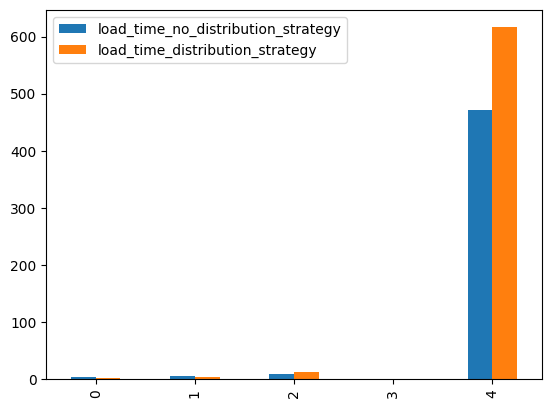

In [153]:
stats = pd.merge(no_distribution_stats, distribution_stats, on='table')
stats.plot.bar()
plt.show()

##### Compare query times

In [154]:
oneDim_SQL = """
SET enable_result_cache_for_session TO OFF;
SET search_path TO {};

SELECT sum(lo_extendedprice*lo_discount) AS revenue
FROM lineorder, dwdate
WHERE lo_orderdate = d_datekey
AND d_year = 1997 
AND lo_discount between 1 and 3 
AND lo_quantity < 24;
"""

twoDim_SQL= """
SET enable_result_cache_for_session TO OFF;
SET search_path TO {};

SELECT sum(lo_revenue), d_year, p_brand1
FROM lineorder, dwdate, part, supplier
WHERE lo_orderdate = d_datekey
AND lo_partkey = p_partkey
AND lo_suppkey = s_suppkey
AND p_category = 'MFGR#12'
AND s_region = 'AMERICA'
GROUP BY d_year, p_brand1
"""

drill_SQL = """
SET enable_result_cache_for_session TO OFF;
SET search_path TO {};

SELECT c_city, s_city, d_year, sum(lo_revenue) AS revenue 
FROM customer, lineorder, supplier, dwdate
WHERE lo_custkey = c_custkey
AND lo_suppkey = s_suppkey
AND lo_orderdate = d_datekey
AND (
    c_city='UNITED KI1'
    OR c_city='UNITED KI5'
)
AND (
    s_city='UNITED KI1'
    OR s_city='UNITED KI5'
)
AND d_yearmonth = 'Dec1997'
GROUP BY c_city, s_city, d_year
ORDER BY d_year asc, revenue DESC;
"""

oneDimSameDist_SQL = """
SET enable_result_cache_for_session TO OFF;
SET search_path TO {};

SELECT lo_orderdate, sum(lo_extendedprice*lo_discount) as revenue  
FROM lineorder, part
WHERE lo_partkey  = p_partkey
GROUP BY lo_orderdate
ORDER BY lo_orderdate
"""

def compare_query_times(cursor, schema):

    queryTimes  =[] 

    for query in [oneDim_SQL, twoDim_SQL, drill_SQL, oneDimSameDist_SQL]:
        start_time = time()
        q = query.format(schema)
        cursor.execute(q)
        queryTime = time()- start_time
        queryTimes.append(queryTime)

    return pd.DataFrame({
            "query":[
                "oneDim",
                "twoDim", 
                "drill", 
                "oneDimSameDist"
            ], 
            f"queryTime_{schema}":queryTimes
        }).set_index('query')

In [156]:
no_distribution_query_times = compare_query_times(cursor, 'no_distribution_strategy')
distribution_query_times = compare_query_times(cursor, 'distribution_strategy')

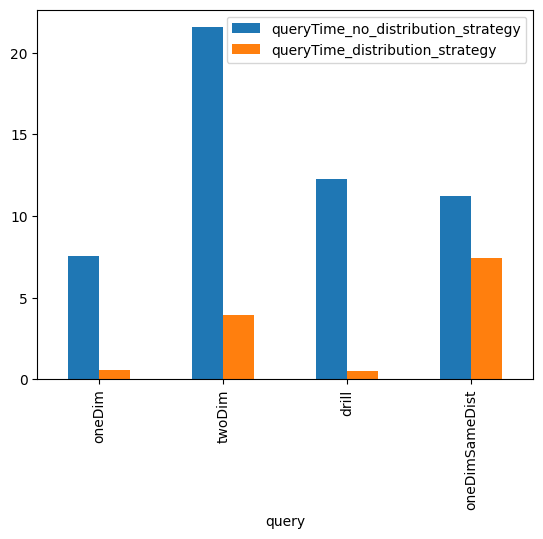

In [157]:
query_times = pd.merge(no_distribution_query_times, distribution_query_times, on='query')
query_times.plot.bar()
plt.show()

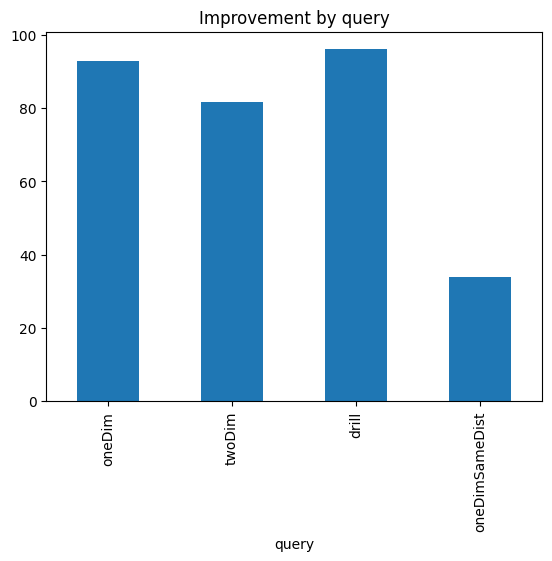

In [158]:
query_times["distImprovement"] = 100.0 * (
    query_times['queryTime_no_distribution_strategy'] - query_times['queryTime_distribution_strategy']
) / query_times['queryTime_no_distribution_strategy']

query_times["distImprovement"].plot.bar(title="Improvement by query")
plt.show()

### Last Step: Clean up your resources

In [159]:
redshift.delete_cluster(
    ClusterIdentifier=DWH_CLUSTER_IDENTIFIER, 
    SkipFinalClusterSnapshot=True
)

{'Cluster': {'ClusterIdentifier': 'dwhcluster',
  'NodeType': 'dc2.large',
  'ClusterStatus': 'deleting',
  'ClusterAvailabilityStatus': 'Modifying',
  'MasterUsername': 'dwhuser',
  'DBName': 'dwh',
  'Endpoint': {'Address': 'dwhcluster.c3plrnxvdgt6.us-west-2.redshift.amazonaws.com',
   'Port': 5439},
  'ClusterCreateTime': datetime.datetime(2023, 3, 14, 8, 55, 4, 561000, tzinfo=tzutc()),
  'AutomatedSnapshotRetentionPeriod': 1,
  'ManualSnapshotRetentionPeriod': -1,
  'ClusterSecurityGroups': [],
  'VpcSecurityGroups': [{'VpcSecurityGroupId': 'sg-0e667ac266e0e88c3',
    'Status': 'active'}],
  'ClusterParameterGroups': [{'ParameterGroupName': 'default.redshift-1.0',
    'ParameterApplyStatus': 'in-sync'}],
  'ClusterSubnetGroupName': 'default',
  'VpcId': 'vpc-05a294b6575b3ad9a',
  'AvailabilityZone': 'us-west-2a',
  'PreferredMaintenanceWindow': 'mon:12:00-mon:12:30',
  'PendingModifiedValues': {},
  'ClusterVersion': '1.0',
  'AllowVersionUpgrade': True,
  'NumberOfNodes': 4,
  'Pu

In [160]:
myClusterProps = redshift.describe_clusters(ClusterIdentifier=DWH_CLUSTER_IDENTIFIER)['Clusters'][0]
prettyRedshiftProps(myClusterProps)

,Key,Value
0,ClusterIdentifier,dwhcluster
1,NodeType,dc2.large
2,ClusterStatus,deleting
3,MasterUsername,dwhuser
4,DBName,dwh
5,Endpoint,{'Port': 5439}
6,VpcId,vpc-05a294b6575b3ad9a
7,NumberOfNodes,4


In [161]:
iam.detach_role_policy(
    RoleName=DWH_IAM_ROLE_NAME, 
    PolicyArn="arn:aws:iam::aws:policy/AmazonS3ReadOnlyAccess"
)
iam.delete_role(RoleName=DWH_IAM_ROLE_NAME)

{'ResponseMetadata': {'RequestId': '464ec75a-3074-494f-a9dd-7c958bab384f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '464ec75a-3074-494f-a9dd-7c958bab384f',
   'content-type': 'text/xml',
   'content-length': '200',
   'date': 'Tue, 14 Mar 2023 10:48:24 GMT'},
  'RetryAttempts': 0}}